# Prompt

You have now learned to decompose a time series into seasonal and trend components and to use time series to forecast into the future using statsmodels. In this activity, your goal is to identify a new (to you) time series dataset and build a forecast using a seasonal and trend additive or multiplicative model using statsmodels.

Summarize your findings in an executive brief that explores the following:

Data description: Provide a high-level overview of your data and its timeframe along with general information on your dataset
Forecast: Give a description of the forecast. Describe the period that was projected and what the forecast implies about your data. Be sure to include presentation-ready plots with appropriate labels and titles.
Uncertainty: Discuss the evaluation of your model on testing data, and explore the residuals. Discuss the consequence of this error for your model and forecasts. Is there still structure to uncover?

# Imports

In [1]:
import warnings
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.filters.filtertools import convolution_filter
from statsmodels.tsa.arima.model import ARIMA

In [2]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
mpl.rcParams.update({"axes.grid": True})

# Data Load

## Data Source
Monthly Water Levels  
- https://tidesandcurrents.noaa.gov/reports.html?type=maxmin&bdate=19800408&edate=20240407&units=standard&datum=MSL&id=9419750&retrieve=Retrieve

## Screengrab
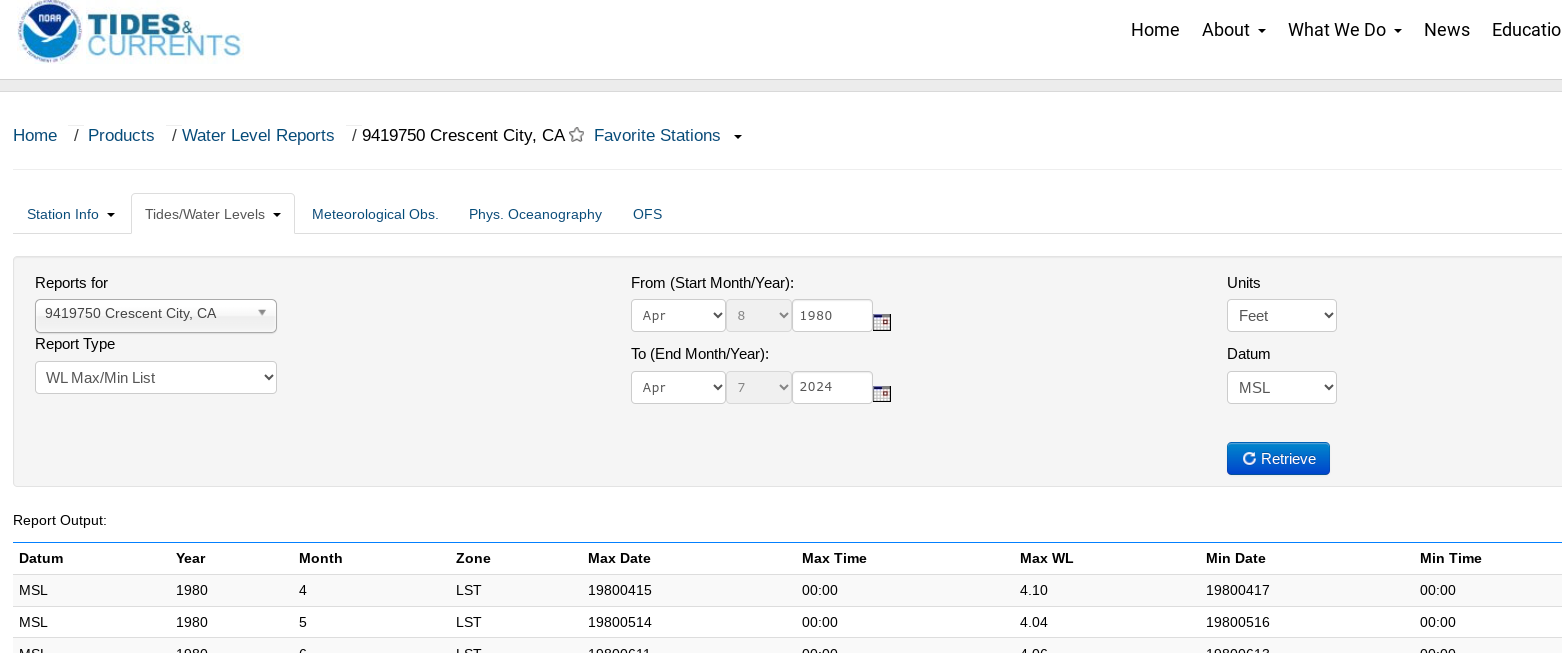

## Data Source
Table Format
- https://tidesandcurrents.noaa.gov/cgi-bin/reports.cgi?type=maxmin&bdate=19800408&datum=MSL&edate=20240407&units=standard&id=9419750&retrieve=&print=1

I took the table format version, copied and pasted into a text file, then fixed a couple of random errors by hand (deleting some random rows)

## Screengrab
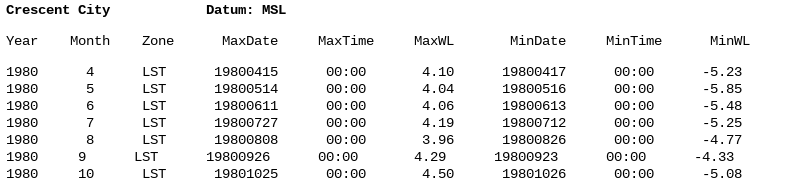

In [3]:
# plt.plot(tides["MinWL"] - tides["MinWL"].mean(), color="blue", label="MinWL")
# plt.plot(tides["MaxWL"] - tides["MaxWL"].mean(), color="red", label="MaxWL")

In [4]:
tides = pd.read_csv("./data/noaa_tides_and_currents_report.txt", delim_whitespace=True)
tides

,Year,Month,Zone,MaxDate,MaxTime,MaxWL,MinDate,MinTime,MinWL
0,1980,4,LST,19800415,00:00,4.10,19800417,00:00,-5.23
1,1980,5,LST,19800514,00:00,4.04,19800516,00:00,-5.85
2,1980,6,LST,19800611,00:00,4.06,19800613,00:00,-5.48
3,1980,7,LST,19800727,00:00,4.19,19800712,00:00,-5.25
4,1980,8,LST,19800808,00:00,3.96,19800826,00:00,-4.77
...,...,...,...,...,...,...,...,...,...
516,2023,11,LST,20231115,19:48,4.55,20231128,01:48,-4.99
517,2023,12,LST,20231227,19:00,5.10,20231215,03:00,-5.34
518,2024,1,LST,20240113,20:24,4.97,20240112,01:54,-6.00
519,2024,2,LST,20240207,16:30,4.68,20240210,01:36,-5.58


In [5]:
# tides["Date"] = pd.to_datetime(tides["MinDate"], format="%Y%m%d")
# Ignore the day of month part of date
tides["Date"] = pd.to_datetime(
    tides["MinDate"].apply(lambda x: str(x)[0:6]), format="%Y%m"
)
tides = (
    tides.set_index("Date")
    .drop(
        columns=[
            "Year",
            "Month",
            "Zone",
            "MaxTime",
            "MinDate",
            "MinTime",
            "MaxDate",
            "MaxWL",
        ]
    )
    .rename(columns={"MinWL": "Water Level"})
)

In [6]:
tides.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 521 entries, 1980-04-01 to 2024-03-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Water Level  521 non-null    float64
dtypes: float64(1)
memory usage: 8.1 KB


In [7]:
tides.head()

,Water Level
Date,
1980-04-01,-5.23
1980-05-01,-5.85
1980-06-01,-5.48
1980-07-01,-5.25
1980-08-01,-4.77


# Data Split

In [8]:
y = tides["Water Level"]

In [9]:
y.describe()

count    521.000000
mean      -5.358138
std        0.590432
min       -6.880000
25%       -5.790000
50%       -5.390000
75%       -4.950000
max       -3.700000
Name: Water Level, dtype: float64

In [10]:
(y_history, y_future) = train_test_split(y, shuffle=False)

In [11]:
[len(y_history), len(y_future)]

[390, 131]

# Period Search

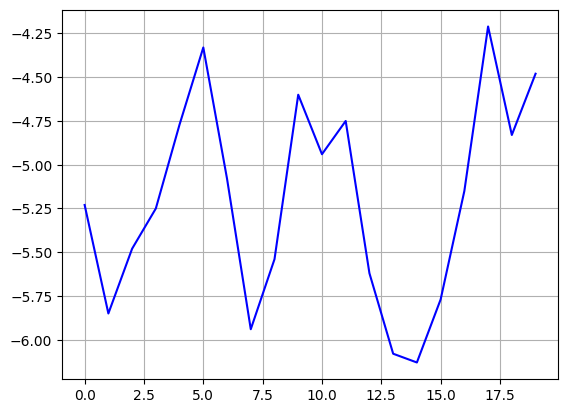

In [12]:
plt.plot(y[0:20].to_numpy(), color="blue")

From the above plot it looked like somewhere about 15 months, so run a search to get best

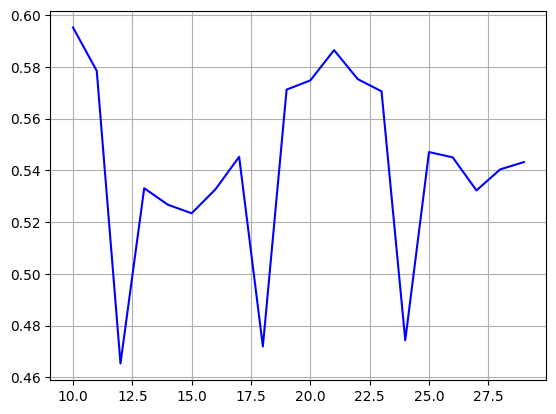

In [13]:
period_guess_list = list(range(10, 30))
errs = []

for period_guess in period_guess_list:
    decomposed = seasonal_decompose(
        y_history,
        model="additive",
        period=period_guess,
        extrapolate_trend=period_guess,
    )

    errs.append(np.sqrt((decomposed.resid**2).mean()))

plt.plot(period_guess_list, errs, "blue")

In [14]:
period = period_guess_list[np.argmin(np.array(errs))]
period

12

# Seasonal Decompose

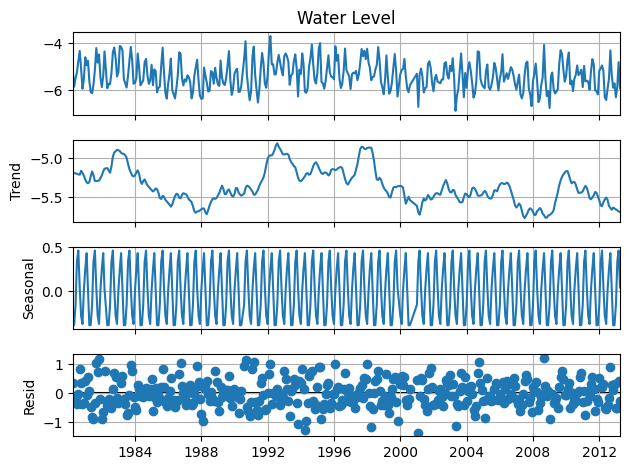

In [15]:
decomposed = seasonal_decompose(
    y_history,
    model="additive",
    period=period,
    extrapolate_trend=period,
)

decomposed.plot()
plt.show()

In [16]:
y_history_modeled = decomposed.trend + decomposed.seasonal

In [17]:
mae = np.abs(decomposed.resid).mean()
rmse = np.sqrt((decomposed.resid**2).mean())
[mae, rmse]

[0.3738738799965764, 0.46532777656106966]

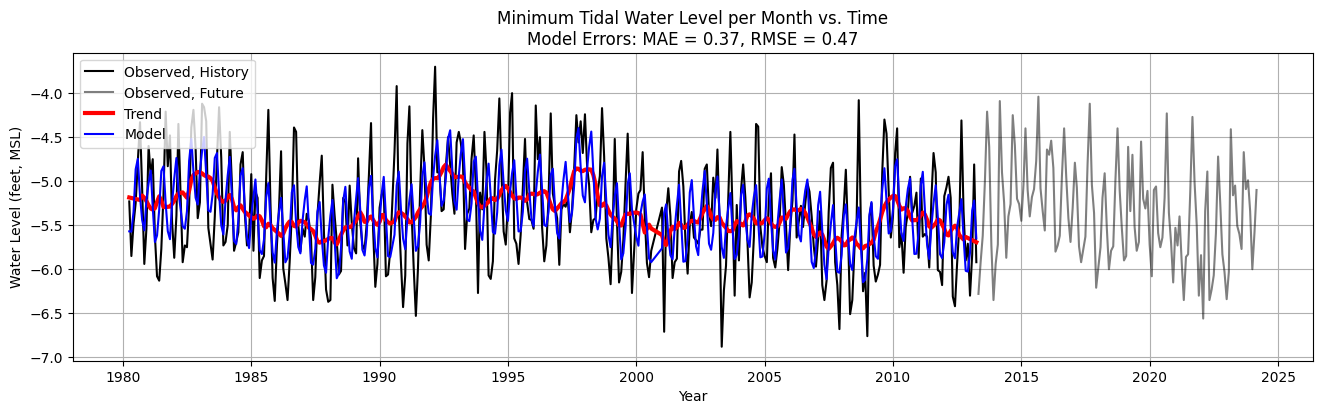

In [18]:
plt.figure(figsize=(16, 4))
plt.plot(y_history, color="black", label="Observed, History")
plt.plot(y_future, color="black", alpha=0.5, label="Observed, Future")
plt.plot(decomposed.trend, color="red", label="Trend", lw=3)
plt.plot(y_history_modeled, color="blue", label="Model")
plt.title(
    "Minimum Tidal Water Level per Month vs. Time\nModel Errors: MAE = %.2f, RMSE = %.2f"
    % (mae, rmse)
)
plt.xlabel("Year")
plt.ylabel("Water Level (feet, MSL)")
plt.legend(loc="upper left")
plt.show()

# STL and STL Forecast

In [19]:
stl = STL(y_history, period=period).fit()
mae_stl = np.abs(stl.resid).mean()
rmse_stl = np.sqrt((stl.resid**2).mean())
[mae_stl, rmse_stl]

[0.245324631799539, 0.3083895737722211]

In [20]:
y_history_modeled_stl = stl.trend + stl.seasonal

In [21]:
stlf = STLForecast(
    y_history, ARIMA, model_kwargs={"order": (1, 1, 0), "trend": "t"}, period=period
).fit()
y_forecast = stlf.forecast(len(y_future))
y_forecast.index = y_future.index

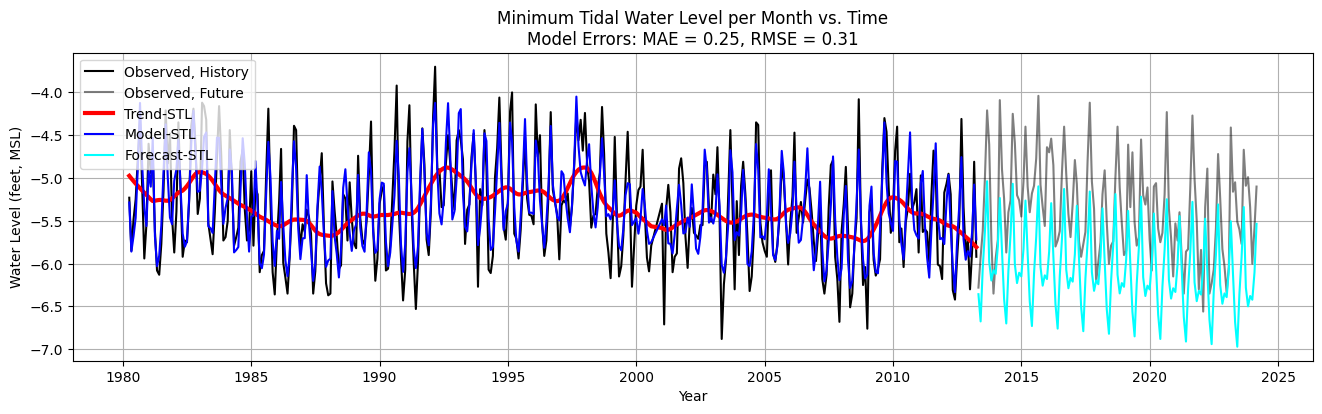

In [22]:
plt.figure(figsize=(16, 4))
plt.plot(y_history, color="black", label="Observed, History")
plt.plot(y_future, color="black", alpha=0.5, label="Observed, Future")
plt.plot(stl.trend, color="red", label="Trend-STL", lw=3)
plt.plot(y_history_modeled_stl, color="blue", label="Model-STL")
plt.plot(y_forecast, color="cyan", label="Forecast-STL")
plt.title(
    "Minimum Tidal Water Level per Month vs. Time\nModel Errors: MAE = %.2f, RMSE = %.2f"
    % (mae_stl, rmse_stl)
)
plt.xlabel("Year")
plt.ylabel("Water Level (feet, MSL)")
plt.legend(loc="upper left")
plt.show()